# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system recognizes diseased cells, and how to design T cells that respond to diseases like cancer.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
from scipy.optimize import least_squares

np.seterr(over='raise')

def Req_func(Phisum, Rtot, L0, KxStar, f, Ka):
    """ Mass balance. Transformation to account for bounds. """
    Req = Rtot / (1.0 + L0 * f * Ka * (1 + Phisum) ** (f - 1))
    return Phisum - Ka * KxStar * Req


def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    assert L0.shape == v.shape

    Ka = 1.0 / Kd
    KxStar = Kx / Ka

    ## Solve Req by calling least_squares
    lsq = least_squares(Req_func, np.ones_like(L0), jac="cs",
                        max_nfev=5000, xtol=1.0E-10, ftol=1.0E-10, gtol=1.0E-10,
                        args=(Rtot, L0, KxStar, v, Ka))

    if lsq['success'] is False:
        print(lsq)
        raise RuntimeError("Failure in solving for Req.")

    Phisum = lsq.x

    # Calculate L, according to equation 7
    Lbound = L0 / KxStar * ((1 + Phisum) ** v - 1)

    # Calculate Rmulti from equation 5
    Rmulti = L0 / KxStar * v * Phisum * ((1 + Phisum) ** (v - 1) - 1)

    # Calculate Rbound
    Rbnd = L0 / KxStar * v * Phisum * (1 + Phisum) ** (v - 1)

    return Lbound, Rbnd, Rmulti

Xs = np.array([8.1E-11, 3.4E-10, 1.3E-09, 5.7E-09, 2.1E-08, 8.7E-08, 3.4E-07, 1.5E-06, 5.7E-06, 2.82E-11, 1.17E-10, 4.68E-10, 1.79E-09, 7.16E-09, 2.87E-08, 1.21E-07, 4.5E-07, 1.87E-06, 1.64E-11, 6.93E-11, 2.58E-10, 1.11E-09, 4.35E-09, 1.79E-08, 7.38E-08, 2.9E-07, 1.14E-06])
Ys = np.array([-196, -436, 761, 685, 3279, 7802, 11669, 12538, 9012, -1104, -769, 1455, 2693, 7134, 11288, 14498, 16188, 13237, 988, 1734, 4491, 9015, 13580, 17159, 18438, 18485, 17958])
Vs = np.repeat([2, 3, 4], 9)

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

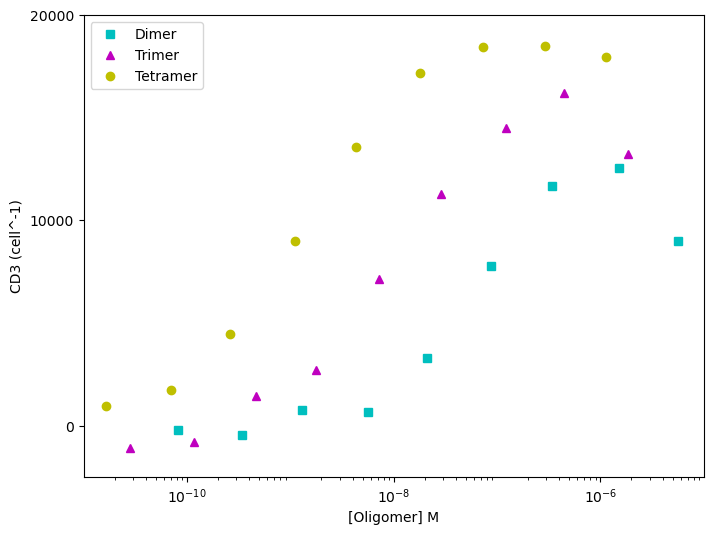

In [2]:
def plot_valency(Xs, Ys, Vs, linestyle='-', markers=None, colors=None):
    # Setting colors
    if colors is None:
        colors = ['c', 'm', 'y']
    
    # Iterate through the range of 3 values
    for val in range(3):
        # If markers are provided
        if markers:
            # Plot the data with markers for each valency
            plt.semilogx(Xs[Vs == val + 2], 
                         Ys[Vs == val + 2],
                         marker=markers[val],
                         linestyle=linestyle,
                         color=colors[val])
        # If markers are not provided
        else:
            # Plot the data without markers for each valency
            plt.semilogx(Xs[Vs == val + 2], 
                         Ys[Vs == val + 2],
                         linestyle=linestyle,
                         color=colors[val])

            
def setup_plot():
    # Set the Y-axis limit
    plt.ylim([-2500, 20000])
    # Set the Y-axis ticks
    plt.yticks([0, 10000, 20000])
    # Set the X-axis limit
    plt.xlim([1E-11, 1E-5])
    # Set the X-axis ticks
    plt.xticks([1E-10, 1E-8, 1E-6])
    # Set the Y-axis label
    plt.ylabel('CD3 (cell^-1)')
    # Set the X-axis label
    plt.xlabel('[Oligomer] M')

# Initialize a new plot with a specified size
plt.figure(figsize=(8, 6))
# Plot the data with specified markers and linestyle
plot_valency(Xs, Ys, Vs, linestyle='', markers=['s', '^', 'o'])
# Set up the plot with specified axis limits, ticks, labels, etc.
setup_plot()
# Add a legend to the plot
plt.legend(['Dimer', 'Trimer', 'Tetramer'])
# Show the plot
plt.show()


#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

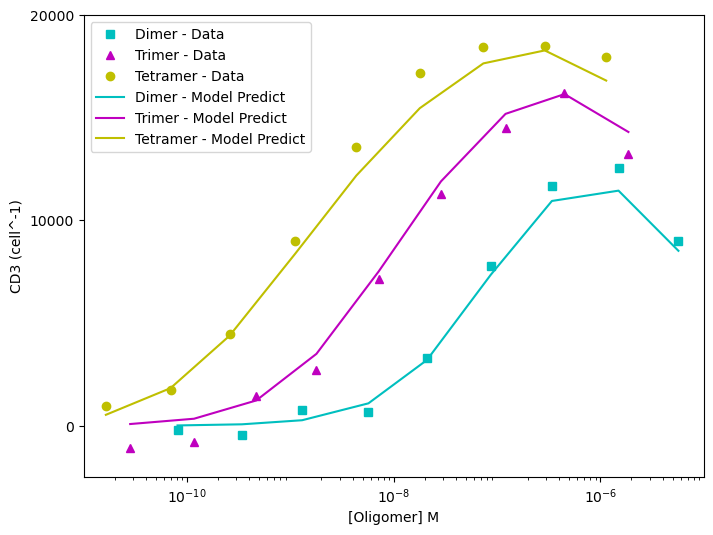

In [3]:
def factor_model_prediction(factor, Rtot, Kd, v, Kx, L0):
    """
    Computes the factor model prediction using the Stone model.
    :param factor: The model factor.
    :param Rtot: Total concentration.
    :param Kd: Dissociation constant.
    :param v: Valency.
    :param Kx: Association constant.
    :param L0: Initial ligand concentration.
    :return: The factor model prediction.
    """
    (Lbound, Rbnd, Rmulti) = StoneMod(Rtot, Kd, v, Kx, L0)
    return factor * Rmulti

Rtot = 24000
Kd = 1.7E-6
Kx = 3.15E-4
factor = 1

# Calculate the factor model predictions using the Stone model
factor_model = factor_model_prediction(factor, Rtot, Kd, Vs, Kx, Xs)

# Plot the data and model predictions
plt.figure(figsize=(8, 6))
plot_valency(Xs, Ys, Vs, linestyle='', markers=['s', '^', 'o'])
plot_valency(Xs, factor_model, Vs, colors=['c', 'm', 'y'])
setup_plot()
plt.legend(['Dimer - Data', 'Trimer - Data', 'Tetramer - Data',
            'Dimer - Model Predict', 'Trimer - Model Predict',
            'Tetramer - Model Predict'])

plt.show()


#### (3) Now use `scipy.optimize.least_squares` to find the least squares solution.

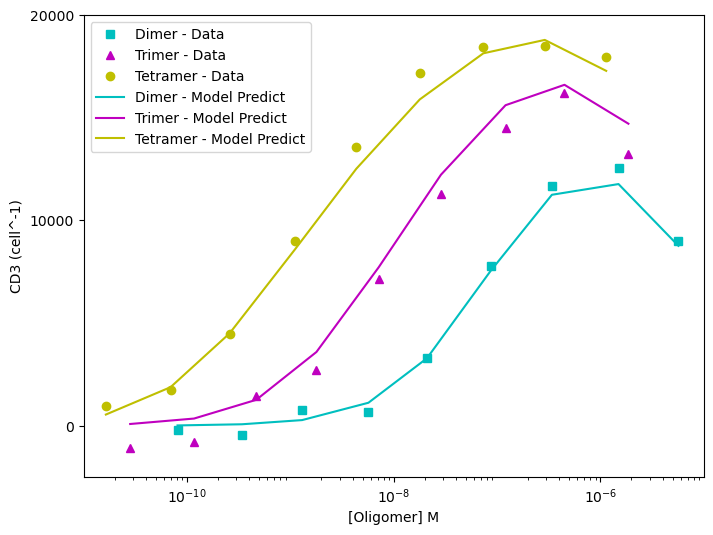

In [4]:
# lsq_problem is a function that takes in 5 parameters and returns a numpy array representing the difference between the prediction of the factor model and the actual Ys
def lsq_problem(params, Rtot, Vs, L0, Ys):
    # Unpack the parameters into factor, Kd, and Kx
    factor = params[0]
    Kd = params[1]
    Kx = params[2]
    # Calculate the difference between the prediction of the factor model and the actual Ys
    return Ys - factor_model_prediction(factor, Rtot, Kd, Vs, Kx, L0)

# factor_guess is a scalar representing the initial guess for the factor in the least squares optimization
factor_guess = 1
# params_guess is a list representing the initial guesses for the parameters in the least squares optimization
params_guess = [factor_guess, Kd, Kx]
# lsq_params is a scipy.optimize.OptimizeResult object, which contains the optimal parameters obtained by the least squares optimization
lsq_params = least_squares(lsq_problem, params_guess, args=(Rtot, Vs, Xs, Ys))

# Unpack the optimal parameters obtained by the least squares optimization
lsq_factor = lsq_params.x[0]
lsq_kd = lsq_params.x[1]
lsq_kx = lsq_params.x[2]

# factor_model is a numpy array representing the predictions of the factor model using the optimal parameters
factor_model = factor_model_prediction(lsq_factor, Rtot, lsq_kd, Vs, lsq_kx, Xs)

# Create a figure with specified size and plot the valency data and the valency model prediction
plt.figure(figsize=(8, 6))
plot_valency(Xs, Ys, Vs, linestyle='', markers=['s', '^', 'o'])
plot_valency(Xs, factor_model, Vs, colors=['c', 'm', 'y'])
setup_plot()
# Add a legend to the plot
plt.legend(['Dimer - Data', 'Trimer - Data', 'Tetramer - Data',
            'Dimer - Model Predict', 'Trimer - Model Predict',
            'Tetramer - Model Predict'])
# Display the plot
plt.show()


#### (4) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

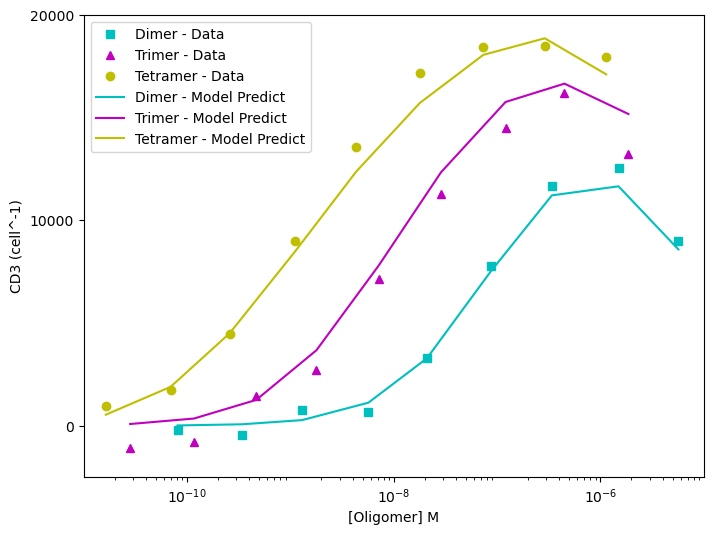

R-Squared score: 0.9853101569618764


In [5]:
# Importing necessary libraries
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

# Initial factor guess value
factor_guess = 1

# Initial parameter guess
params_guess = [factor_guess, Kd, Kx]

# Leave-one-out cross-validation (LOO-CV)
loo_cv = LeaveOneOut()

# Initialize arrays to store cross-validation data and predictions
X_cv = np.empty_like(Xs)
V_cv = np.empty_like(Vs)
cv_predict = np.empty_like(Ys) 

# Iterate over LOO-CV splits
for train_index, test_index in loo_cv.split(Xs):
    # Split data into train and test sets for this split
    X_train, X_test = Xs[train_index], Xs[test_index]
    Y_train, Y_test = Ys[train_index], Ys[test_index]
    V_train, V_test = Vs[train_index], Vs[test_index]
    
    # Optimize factor and Kd, Kx parameters on training data
    lsq_params = least_squares(lsq_problem, params_guess, args=(Rtot, V_train, X_train, Y_train))
    lsq_factor = lsq_params.x[0]
    lsq_kd = lsq_params.x[1]
    lsq_kx = lsq_params.x[2]
    
    # Make prediction on test data for this split
    prediction = factor_model_prediction(lsq_factor, Rtot, lsq_kd, V_test, lsq_kx, X_test)
    
    # Store data and predictions for this split
    X_cv[test_index] = X_test[0]
    cv_predict[test_index] = prediction[0]
    V_cv[test_index] = V_test[0]
    
# Plot LOO-CV predictions vs data
plt.figure(figsize=(8, 6))
plot_valency(Xs, Ys, Vs, linestyle='', markers=['s', '^', 'o'])
plot_valency(X_cv, cv_predict, V_cv, colors=['c', 'm', 'y'])
setup_plot()
plt.legend(['Dimer - Data', 'Trimer - Data', 'Tetramer - Data',
            'Dimer - Model Predict', 'Trimer - Model Predict',
            'Tetramer - Model Predict'])

plt.show()

# Print R-Squared score
print(f'R-Squared score: {r2_score(Ys, cv_predict)}')


#### (5) Using bootstrap estimation, plot the confidence interval of the model predictions along with the data points.
"Confidence interval" does not have a precise definition. For example, you could show the interval over which 50% of the bootstrap samples fall (25th to 75th quantile).

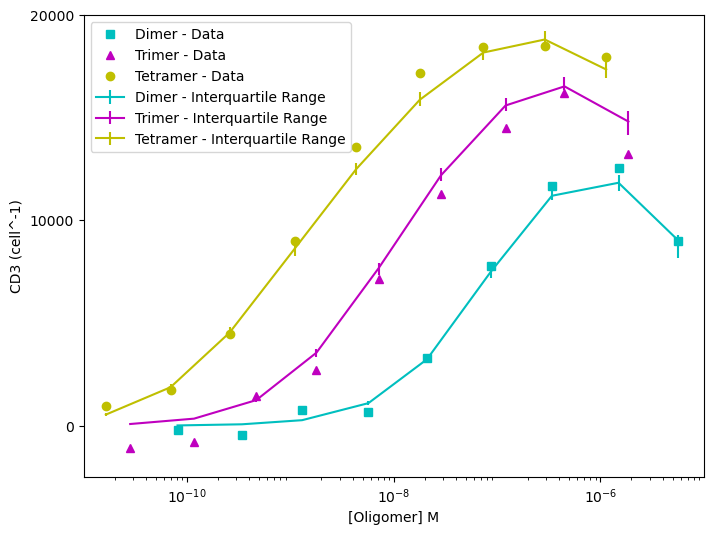

In [6]:
# Import required libraries
import pandas as pd
from sklearn.utils import resample

# Define constant parameters
Rtot = 24000
Kd = 1.7E-6
Kx = 3.15E-4

# Number of bootstraps for the bootstrapping process
n_bootstraps = 100

# Initial guess for the factor to be determined
factor_guess = 1

# Define the initial parameters guess for the optimization
params_guess = [factor_guess, Kd, Kx]

# Determine the number of samples to use in each iteration of the bootstrapping process
n_samples = len(Xs) // 2

# Initialize a DataFrame to store the predictions from each iteration
boot_prediction = pd.DataFrame(index=range(n_bootstraps), columns=range(len(Xs)))

# Loop over each iteration of the bootstrapping process
for boot_index in range(n_bootstraps):
    
    # Resample the data using the specified number of samples
    X_train, Y_train, V_train = resample(Xs, Ys, Vs, replace=True, n_samples=n_samples)
    
    # Use the optimization function to fit the model to the resampled data
    lsq_params = least_squares(lsq_problem, params_guess, args=(Rtot, V_train, X_train, Y_train))
    
    # Extract the optimized factor, Kd, and Kx from the optimization results
    lsq_factor = lsq_params.x[0]
    lsq_kd = lsq_params.x[1]
    lsq_kx = lsq_params.x[2]
    
    # Use the optimized factor, Kd, and Kx to make predictions using the factor model
    prediction = factor_model_prediction(lsq_factor, Rtot, lsq_kd, Vs, lsq_kx, Xs)
    
    # Store the predictions in the DataFrame
    boot_prediction.loc[boot_index, :] = prediction
    
# Calculate the median of the predictions from each iteration
medians = boot_prediction.apply(np.percentile, args=(50,))

# Calculate the 75th percentile of the predictions from each iteration
p_75 = boot_prediction.apply(np.percentile, args=(75,))

# Calculate the 25th percentile of the predictions from each iteration
p_25 = boot_prediction.apply(np.percentile, args=(25,))

# Calculate the interquartile range for each prediction
error_bars = pd.DataFrame([medians - p_25, p_75 - medians])

# Specify colors for each type of molecule
colors = ['c', 'm', 'y']

# Plot the results
plt.figure(figsize=(8, 6))

# Plot the original data
plot_valency(Xs, Ys, Vs, linestyle='', markers=['s', '^', 'o'])

# Set up the plot
setup_plot()

# Plot the interquartile range for each prediction
for i in range(3):
    plt.errorbar(Xs[9*i:9*(i+1)], medians.iloc[9*i:9*(i+1)], 
                 yerr=np.array(error_bars.iloc[:, 9*i:9*(i+1)]), 
                 color=colors[i])

# Add a legend to the plot
plt.legend(['Dimer - Data', 'Trimer - Data', 'Tetramer - Data',
            'Dimer - Interquartile Range', 'Trimer - Interquartile Range',
            'Tetramer - Interquartile Range'])
# Display the plot
plt.show()

#### (6) How would you expect the cross-validation and bootstrap results to change if you had fewer data points?

Explain your answer.

Expect small decrease in goodness-of-fit for cross-validation results but not significant reduction in accuracy. Cross-validation is relatively resilient to sparse data and creates more data to train against by creating folds. However, some decrease in prediction accuracy is expected as there are fewer points. For bootstrapping results, expect larger variance and wider intervals for each estimated point. Less data will reduce the ability to fit the curve properly, which leads to greater variability in the bootstrapping folds and greater variance in the predictions.





#### (7) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter influences the fit the most? Which one the least?

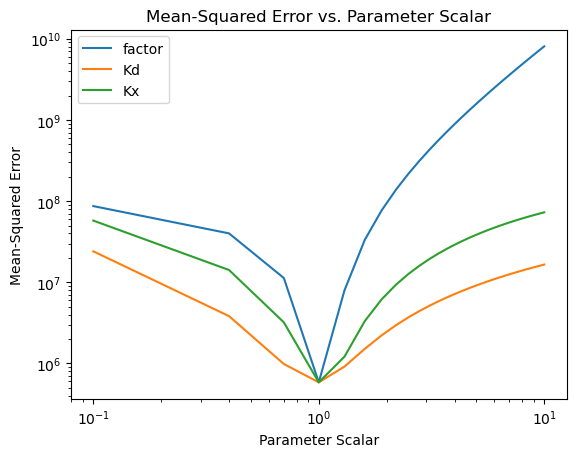

In [7]:
from sklearn.metrics import mean_squared_error

# Define initial parameters
Rtot = 24000
Kd = 1.7E-6
Kx = 3.15E-4
factor = 1
param_models = np.arange(0.1, 10.1, 0.3)

# Initialize lists to store mean-squared errors
mse_factor = []
mse_kd = []
mse_kx = []

# Iterate over different parameter scalars
for param_model in param_models:
    # Compute the mean-squared error for the factord factor parameter
    mod_factor = factor_model_prediction(factor * param_model, Rtot, Kd, Vs, Kx, Xs)
    mse_factor.append(mean_squared_error(mod_factor, Ys))
    
    # Compute the mean-squared error for the factord Kd parameter
    mod_kd = factor_model_prediction(factor, Rtot, Kd * param_model, Vs, Kx, Xs)
    mse_kd.append(mean_squared_error(mod_kd, Ys))
    
    # Compute the mean-squared error for the factord Kx parameter
    mod_kx = factor_model_prediction(factor, Rtot, Kd, Vs, Kx * param_model, Xs)
    mse_kx.append(mean_squared_error(mod_kx, Ys))
    
# Plot the mean-squared error for each parameter scalar
plt.figure()
plt.semilogx(param_models, mse_factor)
plt.semilogx(param_models, mse_kd)
plt.semilogx(param_models, mse_kx)
plt.ylabel('Mean-Squared Error')
plt.xlabel('Parameter Scalar')
plt.xticks([.1, 1, 10])
plt.title('Mean-Squared Error vs. Parameter Scalar')
plt.legend(['factor', 'Kd', 'Kx'])
plt.yscale('log')
plt.show()


The results show that the scale parameter has the biggest impact on the fit and changes to it result in the highest MSE among the three adjustable parameters. On the other hand, Kd has the least impact on the model fit and changes to it lead to the lowest MSE.


#### (8) While easier to perform, a local sensitivity analysis ignores codependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

Expect lower accuracy in parameter predictions from the global analysis due to ignoring codependency in parameters. This introduces additional sources of variance and makes it more challenging for the fitting model to predict parameter values, resulting in less specified values.





#### (9) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How might the other parameters be varying when $K_d$ increases?

Hint: The easiest way to do this is mess with the bounds of the least squares solver.

In [8]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Re-defined StoneMod to remove cost restriction
def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    assert L0.shape == v.shape
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    ## Solve Req by calling least_squares
    lsq = least_squares(diffFunAnon, np.full_like(L0, Rtot/2.0), jac_sparsity=np.eye(L0.size),
                        max_nfev=1000, xtol=1.0E-10, ftol=1.0E-10, gtol=1.0E-10,
                        bounds=(np.full_like(L0, -np.finfo(float).eps), np.full_like(L0, Rtot)))
        
    Req = lsq.x
    Lbound = np.zeros(Req.size)
    Rmulti = np.zeros(Req.size)
    Rbnd = np.zeros(Req.size)
    
    for ii, Reqq in enumerate(Req):
        # Calculate vieq from equation 1
        vieq = L0[ii]*Reqq*binom(v[ii], np.arange(1, v[ii] + 1))*np.power(Kx*Reqq, np.arange(v[ii]))/Kd

        # Calculate L, according to equation 7
        Lbound[ii] = np.sum(vieq)

        # Calculate Rmulti from equation 5
        Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))

        # Calculate Rbound
        Rbnd[ii] = Rmulti[ii] + vieq[0]

    return (Lbound, Rbnd, Rmulti)


Rtot = 24000
Kd = 1.7E-6
Kx = 3.15E-4
factor = 1
param_models = np.arange(0.1, 10.1, 0.3)

mse_factor = []
mse_kd = []
mse_kx = [] 

for param_model in tqdm(param_models):
    factor_guess = [factor * param_model, Kd, Kx]
    factor_params = least_squares(lsq_problem, factor_guess, args=(Rtot, Vs, Xs, Ys),
                                 bounds=([param_model * factor - 1E-4, 0, 0],
                                         [param_model * factor + 1E-4, 1, 1]))
    fix_factor = factor_model_prediction(factor_params.x[0], Rtot, factor_params.x[1], Vs, factor_params.x[2], Xs)
    mse_factor.append(mean_squared_error(fix_factor, Ys))
    
    kd_guess = [factor, Kd * param_model, Kx]
    kd_params = least_squares(lsq_problem, kd_guess, args=(Rtot, Vs, Xs, Ys),
                              bounds=([0, param_model * Kd - 1E-4, 0],
                                      [10, param_model * Kd + 1E-4, 1]))
    fix_kd = factor_model_prediction(kd_params.x[0], Rtot, kd_params.x[1], Vs, kd_params.x[2], Xs)
    mse_kd.append(mean_squared_error(fix_kd, Ys))
    
    kx_guess = [factor, Kd, Kx * param_model]
    kx_params = least_squares(lsq_problem, kx_guess, args=(Rtot, Vs, Xs, Ys),
                           bounds=([0, 0, param_model * Kx - 1E-4],
                                   [10, 1, param_model * Kx + 1E-4]))
    fix_kx = factor_model_prediction(kx_params.x[0], Rtot, kx_params.x[1], Vs, kx_params.x[2], Xs)
    mse_kx.append(mean_squared_error(fix_kx, Ys))

  0%|                                                    | 0/34 [00:00<?, ?it/s]/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))
/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance

 15%|██████▍                                     | 5/34 [02:24<09:35, 19.85s/it]/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))
/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance

 29%|████████████▋                              | 10/34 [03:26<05:44, 14.36s/it]/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))
/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance

 44%|██████████████████▉                        | 15/34 [04:56<05:33, 17.54s/it]/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))
/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance

 59%|█████████████████████████▎                 | 20/34 [06:08<03:23, 14.50s/it]/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))
/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance

 74%|███████████████████████████████▌           | 25/34 [07:27<02:23, 15.89s/it]/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))
/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance

 88%|█████████████████████████████████████▉     | 30/34 [09:03<01:15, 18.83s/it]/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))
/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance

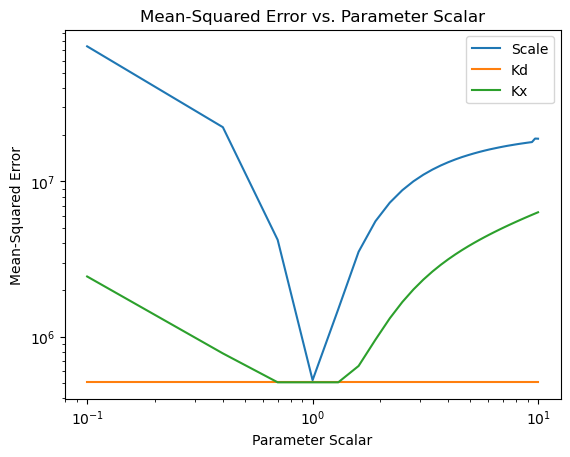

In [9]:
# Plot the mean-squared error for each parameter scalar
plt.figure()
plt.semilogx(param_models, mse_factor)
plt.semilogx(param_models, mse_kd)
plt.semilogx(param_models, mse_kx)
plt.ylabel('Mean-Squared Error')
plt.xlabel('Parameter Scalar')
plt.xticks([.1, 1, 10])
plt.title('Mean-Squared Error vs. Parameter Scalar')
plt.legend(['Scale', 'Kd', 'Kx'])
plt.yscale('log')
plt.show()


My prediction was correct because: 

- The parameter prediction is less specified under global analysis compared to local analysis as the MSE is lower for perturbed values.
- The MSE is constant for all perturbed values of Kd, indicating that the least-squares fitting might be modifying the other parameters (scale and Kx) to offset the increase in Kd.
- In the Stone Model, it's possible that modifications in scale and Kx parameters could negate increases in Kd.

#### (10) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters.

/var/folders/2v/rqzdmr5s1q1d9vqx9sm4tn600000gn/T/ipykernel_77115/1204411945.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))


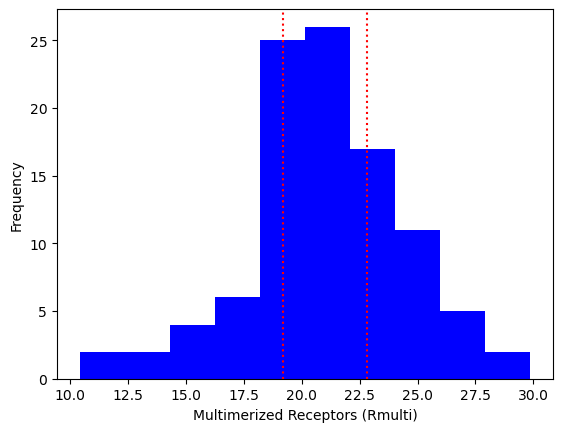

25th Percentile for Rmulti: 19.166376982850352
75th Percentile for Rmulti: 22.8235493313246


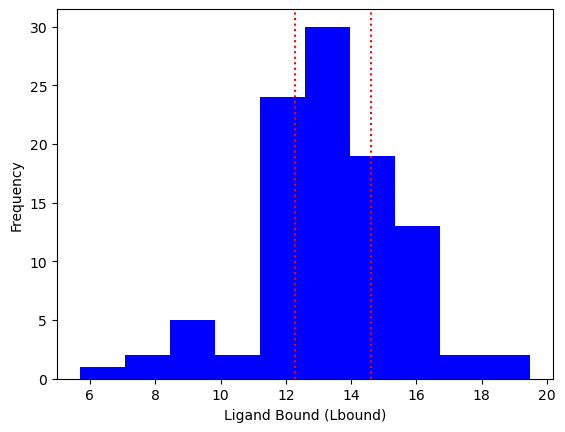

25th Percentile for Lbound: 12.294212209480005
75th Percentile for Lbound: 14.604543551499079


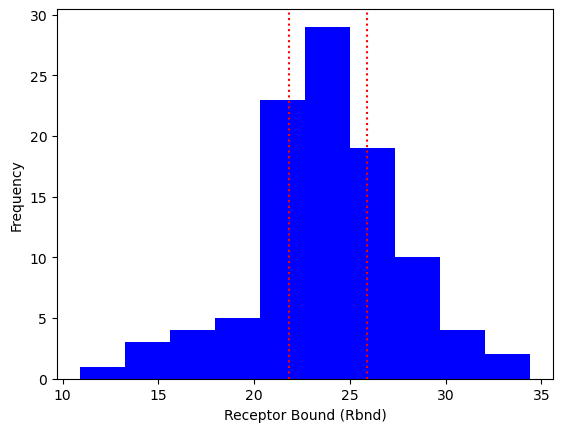

25th Percentile for Rbnd: 21.84052810607079
75th Percentile for Rbnd: 25.912331755979285


In [12]:
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt

def factor_model_prediction_all(factor, Rtot, Kd, v, Kx, L0):
    # Define the model function for prediction
    (Lbound, Rbnd, Rmulti) = StoneMod(Rtot, Kd, v, Kx, L0)
    return factor * Rmulti, factor * Lbound, factor * Rbnd

# Define the initial parameters
Rtot = 24000
Kd = 1.7E-6
Kx = 3.15E-4
n_bootstraps = 100
factor_guess = 1
params_guess = [factor_guess, Kd, Kx]

n_samples = len(Xs) // 2
boot_pred = pd.DataFrame(index=range(n_bootstraps), columns=range(len(Xs)))

# Define the lists for storing the results
multi_distribution  = []
ligand_distribution = []
receptor_distribution  = []

# Perform bootstrapping
for boot_index in range(n_bootstraps):
    X_train, Y_train, V_train = resample(Xs, Ys, Vs, replace=True, n_samples=n_samples)
    
    # Perform least squares optimization
    lsq_params = least_squares(lsq_problem, params_guess, args=(Rtot, V_train, X_train, Y_train))
    lsq_factor = lsq_params.x[0]
    lsq_kd = lsq_params.x[1]
    lsq_kx = lsq_params.x[2]
    
    # Calculate the predicted values
    (Rmulti, Lbound, Rbnd) = scale_model_prediction_all(lsq_scale, Rtot, lsq_kd, np.array([2]), lsq_kx, np.array([1E-10]))
    
    # Store the results
    multi_distribution .append(Rmulti[0])
    ligand_distribution.append(Lbound[0])
    receptor_distribution .append(Rbnd[0])

# Calculate the percentiles of the results
multi_75 = np.percentile(multi_distribution, 75)
multi_25 = np.percentile(multi_distribution, 25)

ligand_75 = np.percentile(ligand_distribution, 75)
ligand_25 = np.percentile(ligand_distribution, 25)

receptor_75 = np.percentile(receptor_distribution, 75)
receptor_25 = np.percentile(receptor_distribution, 25)

plt.figure()
plt.hist(multi_distribution, color='blue') # Set the color to orange
plt.ylabel('Frequency')
plt.xlabel('Multimerized Receptors (Rmulti)')
plt.axvline(multi_25, color='red', linestyle='dotted')
plt.axvline(multi_75, color='red', linestyle='dotted')
plt.show()
print(f'25th Percentile for Rmulti: {multi_25}')
print(f'75th Percentile for Rmulti: {multi_75}')

plt.figure()
plt.hist(ligand_distribution, color='blue')
plt.ylabel('Frequency')
plt.xlabel('Ligand Bound (Lbound)')
plt.axvline(ligand_25, color='red', linestyle='dotted')
plt.axvline(ligand_75, color='red', linestyle='dotted')
plt.show()
print(f'25th Percentile for Lbound: {ligand_25}') 
print(f'75th Percentile for Lbound: {ligand_75}')

plt.figure()
plt.hist(receptor_distribution , color='blue')
plt.ylabel('Frequency')
plt.xlabel('Receptor Bound (Rbnd)')
plt.axvline(receptor_25, color='red', linestyle='dotted')
plt.axvline(receptor_75, color='red', linestyle='dotted')
plt.show()
print(f'25th Percentile for Rbnd: {receptor_25}')
print(f'75th Percentile for Rbnd: {receptor_75}')